In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from operator import itemgetter
import pygraphviz

In [2]:
os.getcwd()

'/Users/Sophie/Documents/GitHub/Analysis_and_Modelling_Social_Interactions'

# Load the data

In [2]:
# import data
df = pd.read_excel('European_electricity_network_vFinal.xlsx', sheet_name='2014')
df.head()

,Origin_Country,Country_Code,AL,AT,BA,BE,BG,CH,CZ,DE,...,NL,NO,PL,PT,RO,RS,SE,SI,SK,TR
0,Albania,AL,NaN,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,165.0,0.0,0.0,0.0,0.0
1,Austria,AT,0.0,NaN,0.0,0.0,0.0,5821,263.0,5484.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3119.0,0.0,0.0
2,Bosnia and Herzegovina,BA,0.0,0.0,NaN,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,614.0,0.0,0.0,0.0,0.0
3,Belgium,BE,0.0,0.0,0.0,NaN,0.0,0,0.0,0.0,...,3040.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bulgaria,BG,0.0,0.0,0.0,0.0,NaN,0,0.0,0.0,...,0.0,0.0,0.0,0.0,43.0,1514.0,0.0,0.0,0.0,5296.0


In [3]:
# drop unnecessary columns
df_elec = df.drop(['Origin_Country'], axis=1)

# Convert the wide table to long table
Country_list = list(df_elec.columns)
df_elec = df_elec.melt(id_vars=['Country_Code'], value_vars=(Country_list[1:]), var_name='Destination', value_name='Electricity_Flow')
df_elec.rename(columns={'Country_Code':'Origin'}, inplace=True)

# Sort the table based on origin country's name
df_elec.sort_values('Origin', inplace=True, ascending=True)

# Delete NAs (when Origin=Destination)
df_elec.dropna(axis=0, inplace=True) 

# Delete zero-value rows
df_elec = df_elec[df_elec.Electricity_Flow != 0]
df_elec.reset_index(drop=True, inplace=True)

df_elec.head()

,Origin,Destination,Electricity_Flow
0,AL,GR,104.0
1,AL,ME,145.0
2,AL,RS,165.0
3,AT,SI,3119.0
4,AT,DE,5484.0


In [4]:
len(df_elec)

119

# Preparation before creating network

## Create nodes list

In [5]:
node = df_elec['Origin'].unique()
node_list = list(node)
node_list[:5]

['AL', 'AT', 'BA', 'BE', 'BG']

## Calculate edge weights

In [6]:
ebunch = list(df_elec.to_records(index=False))

In [7]:
# use "Electricity_Flow" as weights
weights_list = list(df_elec['Electricity_Flow'])

In [8]:
edge_width_list = [None]*len(weights_list)

# use max(weight) to normalize the size of edges
max_weights = max(weights_list)

for i, weight in enumerate(weights_list):
    edge_width_list[i] = weights_list[i]/max_weights*5

# create an array of edge widths to be assigned to network
edge_width = np.asarray(edge_width_list)

## Calculate node size: total export of each country

In [9]:
# calculate total export for each country
df_total_export = df_elec.groupby(['Origin'], as_index=False).sum()
df_total_export.columns = ['Country', 'Export']
df_total_export.head()

,Country,Export
0,AL,414.0
1,AT,18791.0
2,BA,5998.0
3,BE,4190.0
4,BG,13774.0


In [10]:
# convert export dataframe to np array, to be assigned to node_size
total_export = np.asarray(df_total_export['Export'])

In [11]:
# check top exporting countries
df_total_export_sorted = df_total_export.sort_values(by='Export', ascending=False)
df_total_export_sorted.head()

,Country,Export
12,FR,73575.0
7,DE,68884.0
5,CH,32439.0
30,SE,32348.0
6,CZ,28138.0


# Create networks
## Directed network

In [12]:
G = nx.DiGraph()
G.add_nodes_from(node_list)
G.add_weighted_edges_from(ebunch_to_add=ebunch, weight='weight')

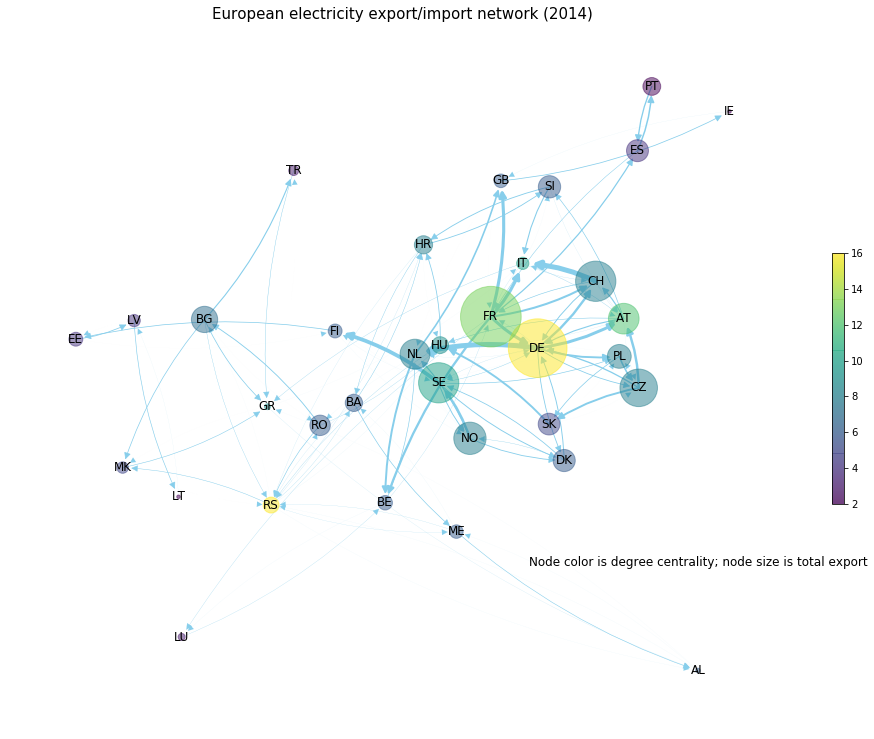

In [14]:
pos = nx.spring_layout(G, k=8, scale=6, seed=15)

node_size = total_export/20
node_color = [float(G.degree(i)) for i in G]

plt.figure(figsize=(15,13))

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, alpha=0.5)
edges = nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='skyblue', 
                       arrowstyle='-|>', arrowsize=14,
                       connectionstyle='arc3,rad=0.1')
nx.draw_networkx_labels(G, pos, font_size=12)

plt.title('European electricity export/import network (2014)', fontsize=15)
plt.text(1.5,-4,'Node color is degree centrality; node size is total export', fontsize=12)
cbar = plt.colorbar(mappable=nodes, cax=None, ax=None, fraction=0.015, pad=0.04)

plt.axis('off')
plt.show()

# plt.margins(0,0)
# plt.savefig("European electricity export/import network (2014).png", dpi=1000)

In [16]:
list(G.degree())

[('AL', 6),
 ('AT', 12),
 ('BA', 6),
 ('BE', 6),
 ('BG', 7),
 ('CH', 8),
 ('CZ', 8),
 ('DE', 16),
 ('DK', 6),
 ('EE', 4),
 ('ES', 4),
 ('FI', 6),
 ('FR', 13),
 ('GB', 6),
 ('GR', 9),
 ('HR', 8),
 ('HU', 9),
 ('IE', 2),
 ('IT', 10),
 ('LT', 2),
 ('LU', 3),
 ('LV', 4),
 ('ME', 6),
 ('MK', 5),
 ('NL', 8),
 ('NO', 8),
 ('PL', 8),
 ('PT', 2),
 ('RO', 6),
 ('RS', 16),
 ('SE', 10),
 ('SI', 6),
 ('SK', 5),
 ('TR', 3)]

In [17]:
nx.betweenness_centrality(G)

{'AL': 0.029338535517512792,
 'AT': 0.2501129153452014,
 'BA': 0.001893939393939394,
 'BE': 0.03985794731115587,
 'BG': 0.01244926948051948,
 'CH': 0.04129203850961871,
 'CZ': 0.031999684343434344,
 'DE': 0.34795376053313887,
 'DK': 0.010615863080769498,
 'EE': 0.11742424242424243,
 'ES': 0.06060606060606061,
 'FI': 0.17045454545454547,
 'FR': 0.28702545412104224,
 'GB': 0.0663730988263074,
 'GR': 0.1620033352528339,
 'HR': 0.04791779401154401,
 'HU': 0.18157356606554467,
 'IE': 0.0,
 'IT': 0.24076907708675752,
 'LT': 0.0,
 'LU': 0.0,
 'LV': 0.06060606060606061,
 'ME': 0.0018150252525252525,
 'MK': 0.009057601174078448,
 'NL': 0.08189235146537953,
 'NO': 0.04608585858585858,
 'PL': 0.045730437491801126,
 'PT': 0.0,
 'RO': 0.014353415264177294,
 'RS': 0.12102934665601778,
 'SE': 0.1904214268351969,
 'SI': 0.0536768865604093,
 'SK': 0.03135228092614456,
 'TR': 0.0}